# Machine Learning

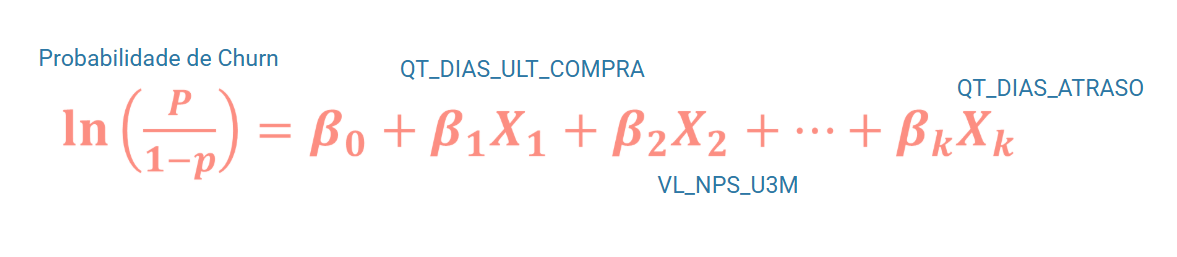

## Lendo bases tratadas

In [ ]:
import pandas as pd

X_train_selected = pd.read_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/abt_fs_train.csv')
X_test_selected = pd.read_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/abt_fs_test.csv')

Y_train_selected = pd.read_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/y_train.csv')
Y_test_selected = pd.read_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/y_test.csv')

X_train_selected.shape, X_test_selected.shape, Y_train_selected.shape, Y_test_selected.shape

((5634, 34), (1409, 34), (5634, 1), (1409, 1))

## Regressão Logística (baseline linear, rápida e interpretável)
A regressão logística modela a probabilidade do evento (churn) com uma fronteira de decisão linear nas features transformadas. Boa como baseline e para entender direção dos efeitos. A grade abaixo testa apenas a regularização C.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logit = LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced")
grid_logit = GridSearchCV(
    estimator=logit,
    param_grid={"C": [0.1, 1, 10]},
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)
grid_logit.fit(X_train_selected, Y_train_selected)
best_logit = grid_logit.best_estimator_
print("Logistic AUC (CV):", grid_logit.best_score_, "| best_params:", grid_logit.best_params_)

Logistic AUC (CV): 0.8459351353172425 | best_params: {'C': 10}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Random Forest (conjunto de árvores, robusto a não linearidades)
Floresta Aleatória constrói muitas árvores de decisão em amostras diferentes e agrega os resultados. Captura interações e não linearidades com pouca preparação de dados. A grade explora nº de árvores e profundidade.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced_subsample")
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid={
        "n_estimators": [200, 500],
        "max_depth": [None, 10],
        "min_samples_leaf": [1, 5]
    },
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)
grid_rf.fit(X_train_selected, Y_train_selected)
best_rf = grid_rf.best_estimator_
print("RF AUC (CV):", grid_rf.best_score_, "| best_params:", grid_rf.best_params_)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF AUC (CV): 0.8462072301699489 | best_params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 500}


## Gradient Boosting (árvores sequenciais, foco em erros residuais)
Gradient Boosting treina árvores fracas em sequência, cada uma corrigindo os erros da anterior. Costuma performar bem em tabular. A grade testa taxa de aprendizado, profundidade e nº de árvores.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid={
        "learning_rate": [0.05, 0.1],
        "n_estimators": [200, 400],
        "max_depth": [2, 3]
    },
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)
grid_gb.fit(X_train_selected, Y_train_selected)
best_gb = grid_gb.best_estimator_
print("GB AUC (CV):", grid_gb.best_score_, "| best_params:", grid_gb.best_params_)


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB AUC (CV): 0.8486530885355198 | best_params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}


## SVM com probabilidade (margem máxima; kernel linear/RBF)
SVC maximiza a margem entre classes. Com probability=True, fornece probabilidades (via Platt scaling), úteis para AUC e threshold tuning. A grade pequena compara kernel e C.

In [ ]:
from sklearn.svm import SVC

svc = SVC(probability=True, class_weight="balanced", random_state=42)
grid_svc = GridSearchCV(
    estimator=svc,
    param_grid={
        "kernel": ["linear", "rbf"],
        "C": [0.5, 1, 2]
    },
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)
grid_svc.fit(X_train_selected, Y_train_selected)
best_svc = grid_svc.best_estimator_
print("SVC AUC (CV):", grid_svc.best_score_, "| best_params:", grid_svc.best_params_)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC AUC (CV): 0.8349800378761376 | best_params: {'C': 2, 'kernel': 'linear'}


## Comparação final de modelos (AUC, Precision, Recall, Gini)

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def eval_model(name, model, X_test, y_test, thr=0.5):
    prob = model.predict_proba(X_test)[:, 1]
    pred = (prob >= thr).astype(int)
    auc  = roc_auc_score(y_test, prob)
    prec = precision_score(y_test, pred, zero_division=0)
    rec  = recall_score(y_test, pred, zero_division=0)
    gini = 2*auc - 1
    return {"model": name, "AUC": auc, "Precision": prec, "Recall": rec, "Gini": gini}

results = []
results.append(eval_model("LogisticRegression", best_logit, X_test_selected, Y_test_selected))
results.append(eval_model("RandomForest",       best_rf,   X_test_selected, Y_test_selected))
results.append(eval_model("GradientBoosting",   best_gb,   X_test_selected, Y_test_selected))
results.append(eval_model("SVC",                best_svc,  X_test_selected, Y_test_selected))

cmp = pd.DataFrame(results).sort_values("AUC", ascending=False).reset_index(drop=True)
cmp


,model,AUC,Precision,Recall,Gini
0,GradientBoosting,0.845688,0.660777,0.500000,0.691377
1,RandomForest,0.843012,0.539499,0.748663,0.686024
2,LogisticRegression,0.840959,0.506920,0.783422,0.681919
3,SVC,0.809974,0.000000,0.000000,0.619949


## Melhores hiperparâmetros

In [ ]:
pd.DataFrame([
    {"model": "LogisticRegression", "best_params": grid_logit.best_params_},
    {"model": "RandomForest",       "best_params": grid_rf.best_params_},
    {"model": "GradientBoosting",   "best_params": grid_gb.best_params_},
    {"model": "SVC",                "best_params": grid_svc.best_params_},
])


,model,best_params
0,LogisticRegression,{'C': 10}
1,RandomForest,"{'max_depth': 10, 'min_samples_leaf': 5, 'n_es..."
2,GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
3,SVC,"{'C': 2, 'kernel': 'linear'}"


## Ordenação dos Modelos

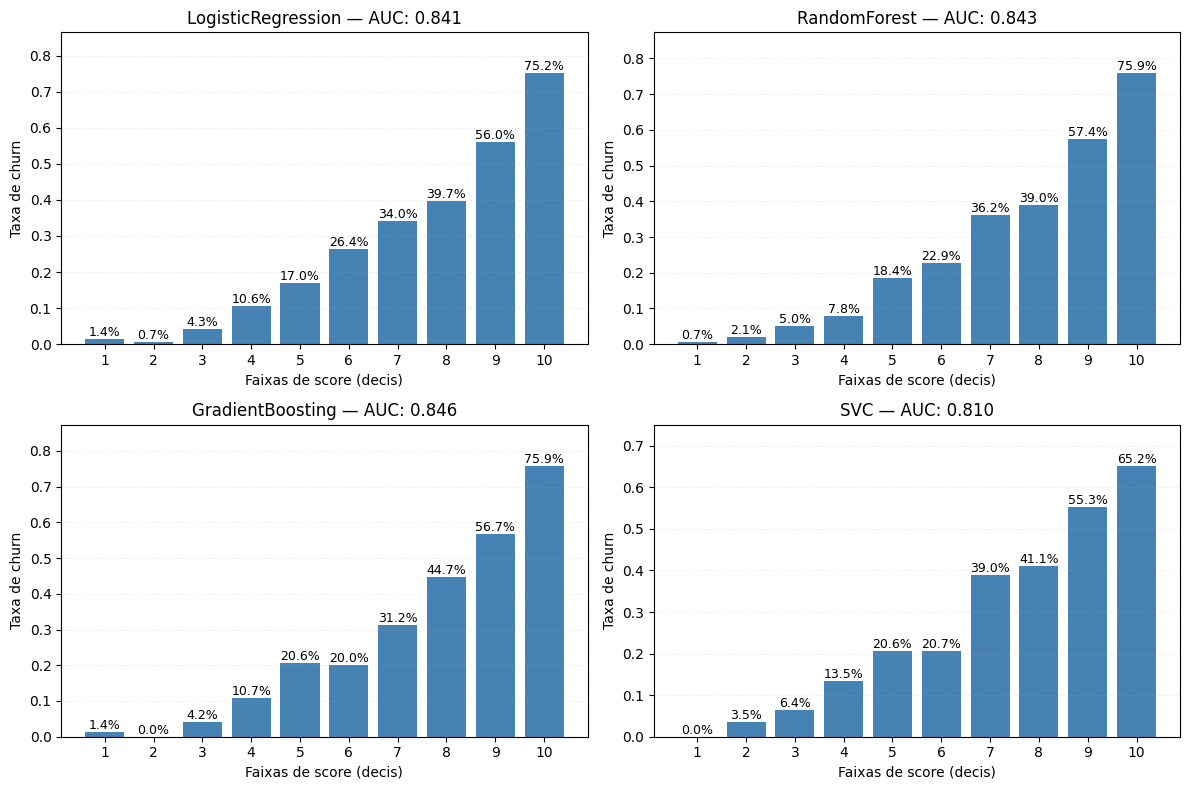

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn.metrics import roc_auc_score

def _to_1d(a):
    if isinstance(a, pd.DataFrame):
        return a.to_numpy().ravel()
    if isinstance(a, pd.Series):
        return a.to_numpy().ravel()
    return np.asarray(a).ravel()

def model_probs(model, X):
    if hasattr(model, "predict_proba"):
        return _to_1d(model.predict_proba(X)[:, 1])
    elif hasattr(model, "decision_function"):
        s = _to_1d(model.decision_function(X))
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        raise ValueError("Modelo não tem predict_proba nem decision_function.")

def decile_plot_for_model(ax, y_true, y_prob, n_bins=10, title=""):
    y_true = _to_1d(y_true)
    y_prob = _to_1d(y_prob)

    # Quantis em categorias; evita problemas de versão usando Categorical diretamente
    q = pd.qcut(y_prob, q=n_bins, duplicates="drop")          # Series ou Categorical
    cats = pd.Categorical(q)                                   # garante Categorical
    k = len(cats.categories)                                   # nº real de faixas (pode < n_bins)
    decil_codes = pd.Series(cats.codes + 1)                    # 1..K ; -1 vira 0+1=0 -> trataremos abaixo
    decil_codes = decil_codes.replace({0: np.nan}) if (cats.codes.min() == -1) else decil_codes

    df_plot = pd.DataFrame({"decil": decil_codes, "y": y_true}).dropna(subset=["decil"])
    grp = df_plot.groupby("decil", observed=True)["y"].mean().reset_index()
    grp = grp.sort_values("decil")

    ax.bar(grp["decil"].astype(int).astype(str), grp["y"], width=0.8, color="steelblue")
    ax.set_xlabel("Faixas de score (decis)")
    ax.set_ylabel("Taxa de churn")
    ax.set_title(title)
    ax.set_ylim(0, max(0.001, grp["y"].max()*1.15))
    for x, v in zip(grp["decil"].astype(int).astype(str), grp["y"].values):
        ax.text(x, v, f"{v:.1%}", ha="center", va="bottom", fontsize=9)
    ax.grid(True, axis="y", linestyle=":", alpha=0.3)

def plot_deciles_grid(models: dict, X_test, y_test, n_bins=10, n_cols=2):
    names = list(models.keys())
    n_models = len(names)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
    axes = np.array(axes).reshape(n_rows, n_cols)

    y_test_1d = _to_1d(y_test)

    for i, name in enumerate(names):
        r, c = divmod(i, n_cols)
        ax = axes[r, c]
        prob = model_probs(models[name], X_test)
        auc = roc_auc_score(y_test_1d, prob)
        title = f"{name} — AUC: {auc:.3f}"
        decile_plot_for_model(ax, y_true=y_test_1d, y_prob=prob, n_bins=n_bins, title=title)

    # remove eixos sobrando
    for j in range(i+1, n_rows*n_cols):
        r, c = divmod(j, n_cols)
        fig.delaxes(axes[r, c])

    plt.tight_layout()
    plt.show()




models = {
    "LogisticRegression": best_logit,
    "RandomForest":       best_rf,
    "GradientBoosting":   best_gb,
    "SVC":                best_svc,
}
plot_deciles_grid(models, X_test_selected, Y_test_selected, n_bins=10, n_cols=2)



## Avaliação de Negócio

Premissas para o Telco Churn

Ticket médio (ARPU): df["MonthlyCharges"].mean()

Margem bruta: vamos assumir ~70% (mas pode parametrizar).

Custo da ação de retenção: por cliente (ex.: R$ 10,00).

Taxa de sucesso (uplift): % dos clientes de fato retidos entre os verdadeiros positivos (ex.: 30%).

k%: fração do portfólio que será abordado (top-N clientes mais arriscados).

In [ ]:
import pandas as pd

abt_00_telcos = pd.read_csv('/content/drive/Shareddrives/PoD Academy/Semana da Ciência de Dados/2025/Dados/abt_00_telcos.csv')
abt_00_telcos["MonthlyCharges"].mean()

np.float64(64.76169246059918)

In [ ]:
import numpy as np
import pandas as pd

def _to_1d(a):
    """Converte Series/DataFrame/ndarray em vetor 1D (ravel)."""
    if isinstance(a, pd.DataFrame):
        # usa a primeira coluna, comum no caso Y_* com uma coluna
        a = a.iloc[:, 0].values
    elif isinstance(a, pd.Series):
        a = a.values
    return np.asarray(a).ravel()

def business_value_roi(y_true, y_prob,
                       k=0.2,           # proporção (0<k<1) OU número absoluto de clientes
                       arpu=None,       # ticket médio (ex.: df["MonthlyCharges"].mean())
                       margem=0.7,      # margem bruta
                       custo_unit=10,   # custo da ação por cliente abordado
                       uplift=0.3):     # % de churners realmente retidos pela ação
    """
    Estima ROI ao abordar os clientes de maior risco segundo o modelo.
    Retorna dict com clientes abordados, churners abordados, receita preservada, custo e ROI.
    """
    y_true = _to_1d(y_true)
    y_prob = _to_1d(y_prob)

    if arpu is None:
        raise ValueError("Passe o ARPU (ex.: df['MonthlyCharges'].mean()).")

    if y_true.shape[0] != y_prob.shape[0]:
        raise ValueError(f"Tamanhos diferentes: y_true={y_true.shape[0]} vs y_prob={y_prob.shape[0]}")

    n = y_prob.shape[0]
    cutoff = int(np.ceil(n * k)) if (isinstance(k, float) and 0 < k < 1) else int(k)
    cutoff = max(1, min(cutoff, n))  # limita aos bounds

    # ordena por score desc e pega top-k por POSIÇÃO
    order = np.argsort(-y_prob)
    top_idx = order[:cutoff]

    # churn real no top-k (TP por cobertura, sem threshold explícito)
    tp = int(y_true[top_idx].sum())

    # Receita preservada: churners retidos * ARPU * margem
    receita = tp * uplift * arpu * margem

    # Custo: todos os abordados * custo unitário
    custo = cutoff * custo_unit

    roi = (receita - custo) / custo if custo > 0 else np.nan

    return {
        "Clientes_abordados": cutoff,
        "Churners_abordados": tp,
        "Receita_preservada": float(receita),
        "Custo_total": float(custo),
        "ROI": float(roi)
    }


In [ ]:
# ARPU dos dados de telco
arpu = 65*5.5

# y_true como vetor 1D — escolha UM dos dois:
y_true = _to_1d(Y_test_selected)               # se você tem DataFrame com 1 coluna ("Churn")
# y_true = _to_1d(y_test)                # se você tem Series/array do split

# Probabilidades do modelo (garanta que o modelo foi treinado nas MESMAS features selecionadas)
probs = best_gb.predict_proba(X_test_selected.values)[:, 1]

res = business_value_roi(
    y_true=y_true,
    y_prob=probs,
    k=0.2,         # abordar top 20% mais arriscados (pode usar um número absoluto também)
    arpu=arpu,
    margem=0.70,
    custo_unit=10,
    uplift=0.30
)
res



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


{'Clientes_abordados': 282,
 'Churners_abordados': 187,
 'Receita_preservada': 14039.025,
 'Custo_total': 2820.0,
 'ROI': 3.978377659574468}

# 📊 Interpretação de Negócio — Modelo de Churn

Com base no modelo de **propensão ao churn**, realizamos uma simulação de impacto financeiro ao abordar os clientes classificados como os **20% mais propensos a cancelar** no próximo ciclo.  

---

## 🔢 Resultados

- **Clientes abordados:** 282  
- **Churners identificados nesse grupo:** 187  
- **Receita preservada estimada:** R$ 14.039,00  

- **Custo operacional da ação:** R$ 2.820,00  
- **ROI estimado:** **3,98**  

---

## 🧩 O que isso significa para o negócio?

- 🎯 **Alta assertividade**: a maioria dos clientes abordados realmente estava em risco de churn.  
- 💰 **Retorno financeiro expressivo**: cada real investido trouxe quase R$ 4,00 em receita preservada.  
- ⚙️ **Eficiência operacional**: a equipe de retenção foca nos casos de maior impacto, otimizando tempo e orçamento.  
- 📈 **Potencial de escala**: a estratégia pode ser ajustada (k%, ofertas de retenção) para ampliar ainda mais o ROI.  

---

## 🚀 Conclusão

O modelo de churn demonstra ser **viável e altamente rentável**, permitindo:  

- Preservar receita recorrente  
- Reduzir custos de aquisição de novos clientes  
- Apoiar decisões de CRM com inteligência de dados  

Esse resultado reforça a importância de integrar modelos preditivos às operações de retenção, trazendo **valor financeiro direto** para o negócio.  
